In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size


In [49]:
def standarize(data, train_mean, std):
    return (data - train_mean) / std

In [50]:
class RNN:
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

        self.w_x = np.random.randn(self.hidden_dimension, self.input_dimension) * 0.01
        self.w_h = np.random.randn(self.hidden_dimension, self.hidden_dimension) * 0.01
        self.w_y = np.random.randn(self.output_dimension, self.hidden_dimension) * 0.01
        
        self.b_h = np.zeros((self.hidden_dimension, 1))
        self.b_y = np.zeros((self.output_dimension, 1))

    def step(self, x_t, h_prev):
        h_t = np.tanh(self.w_x @ x_t + self.w_h @ h_prev + self.b_h)
        y_t = self.w_y @ h_t + self.b_y
        return y_t, h_t
    
    def forward(self, x):
        self.x = x
        self.T = x.shape[0]
        h_prev = np.zeros((self.hidden_dimension, 1))

        y_pred = []
        h_states = []

        for t in range(self.T):
            x_t = self.x[t].reshape(-1, 1)
            y_t, h_t = self.step(x_t, h_prev)
            h_prev = h_t

            y_pred.append(y_t)
            h_states.append(h_t)

        return np.array(y_pred).reshape(-1, 1), h_states
    
    def backward(self, y_true, y_pred, h_states, learning_rate, clip_value):
        dw_x = np.zeros_like(self.w_x)
        dw_h = np.zeros_like(self.w_h)
        dw_y = np.zeros_like(self.w_y)
        
        db_h = np.zeros_like(self.b_h)
        db_y = np.zeros_like(self.b_y)

        dy = mse_derivative(y_true, y_pred)

        dh_next = np.zeros_like(h_states[0])

        for t in reversed(range(self.T)):
            x_t = self.x[t].reshape(1, -1)
            
            dy_t = dy[t].reshape(-1, 1)
            dw_y += dy_t @ h_states[t].T
            db_y += dy_t

            dh = self.w_y.T @ dy_t + dh_next
            dh_raw = (1 - h_states[t] ** 2) * dh

            dw_x += dh_raw @ x_t
            if t > 0:
                dw_h += dh_raw @ h_states[t - 1].T
            else:
                dw_h += dh_raw @ np.zeros_like(h_states[t]).T
            db_h += dh_raw

            dh_next = self.w_h.T @ dh_raw
        
        for gradient in [dw_x, dw_h, dw_y, db_h, db_y]:
            np.clip(gradient, -clip_value, clip_value, out=gradient)

        self.w_x -= learning_rate * dw_x
        self.w_h -= learning_rate * dw_h
        self.w_y -= learning_rate * dw_y

        self.b_h -= learning_rate * db_h
        self.b_y -= learning_rate * db_y

    def train(self, x, y, epochs, learning_rate, clip_value):
        loss_list = []

        for epoch in range(epochs):
            y_pred, h_states = self.forward(x)
            self.backward(y, y_pred, h_states, learning_rate, clip_value)

            loss = mse(y, y_pred)
            loss_list.append(loss)

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
            
        return loss_list


In [51]:
file_path = '../../Datasets/조업편차분석.csv'
data = pd.read_csv(file_path)

data['Origin'] = data.index
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(len(shuffled_data) * 0.8)
train_data, test_data = shuffled_data.iloc[:train_size], shuffled_data.iloc[train_size:]

x_train, y_train = train_data.drop(columns=['No.', 'A1', 'Origin'], axis=1), train_data['A1']

x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
y_train_mean = np.mean(y_train, axis=0)
y_train_std = np.std(y_train, axis=0)

x_train = standarize(x_train, x_train_mean, x_train_std).to_numpy()
y_train = standarize(y_train, y_train_mean, y_train_std).to_numpy().reshape(-1, 1)

test_data_sorted = test_data.sort_values(by='Origin').reset_index(drop=True)

x_test_sorted, y_test_sorted = test_data_sorted.drop(columns=['No.', 'A1', 'Origin'], axis=1), test_data_sorted['A1']
x_test_sorted = standarize(x_test_sorted, x_train_mean, x_train_std).to_numpy()
y_test_sorted = standarize(y_test_sorted, y_train_mean, y_train_std).to_numpy().reshape(-1, 1)

In [52]:
rnn_model = RNN(
    input_dimension=53,
    hidden_dimension=64,
    output_dimension=1
)

In [53]:
rnn_model.train(
    x=x_train,
    y=y_train,
    epochs=500,
    learning_rate=0.01,
    clip_value=1.0
)

Epoch 100, Loss: 0.05796455969650674
Epoch 200, Loss: 0.027757796524422965
Epoch 300, Loss: 0.022553144172264575
Epoch 400, Loss: 0.020358998477433363
Epoch 500, Loss: 0.01909719283030711


[0.9957535663458187,
 0.9912059920251314,
 0.9866138961195527,
 0.9819274762760622,
 0.9770978148757866,
 0.9720765128217576,
 0.9668153964887822,
 0.9612662987111287,
 0.9553809165442261,
 0.9491107500950152,
 0.9424071279310493,
 0.9352213253852659,
 0.9275047823845701,
 0.9192094271428629,
 0.910288111061064,
 0.9006951583577066,
 0.8903870312182366,
 0.8793231075343954,
 0.8674665635911375,
 0.8547853483997866,
 0.8412532299118279,
 0.8268508863198233,
 0.8115670084154146,
 0.7953993719990273,
 0.7783558331963273,
 0.760455194887346,
 0.7417278899882782,
 0.7222164277141693,
 0.7019755527657998,
 0.6810720750129262,
 0.6595843388001054,
 0.6376013162385411,
 0.6152213271215895,
 0.5925504083559238,
 0.5697003766170226,
 0.5467866476483904,
 0.5239258924756441,
 0.5012336231632127,
 0.47882180729369916,
 0.45679661029944263,
 0.4352563579595389,
 0.41428979830792184,
 0.3939747240190914,
 0.3743769946752965,
 0.35554997508529596,
 0.3375343829854931,
 0.3203585188006895,
 0.30403883

In [54]:
x_train[0].reshape(-1, 1).shape

(53, 1)

In [62]:
y_pred, _ = rnn_model.forward(x_test_sorted)

In [61]:
len(y_pred)

2

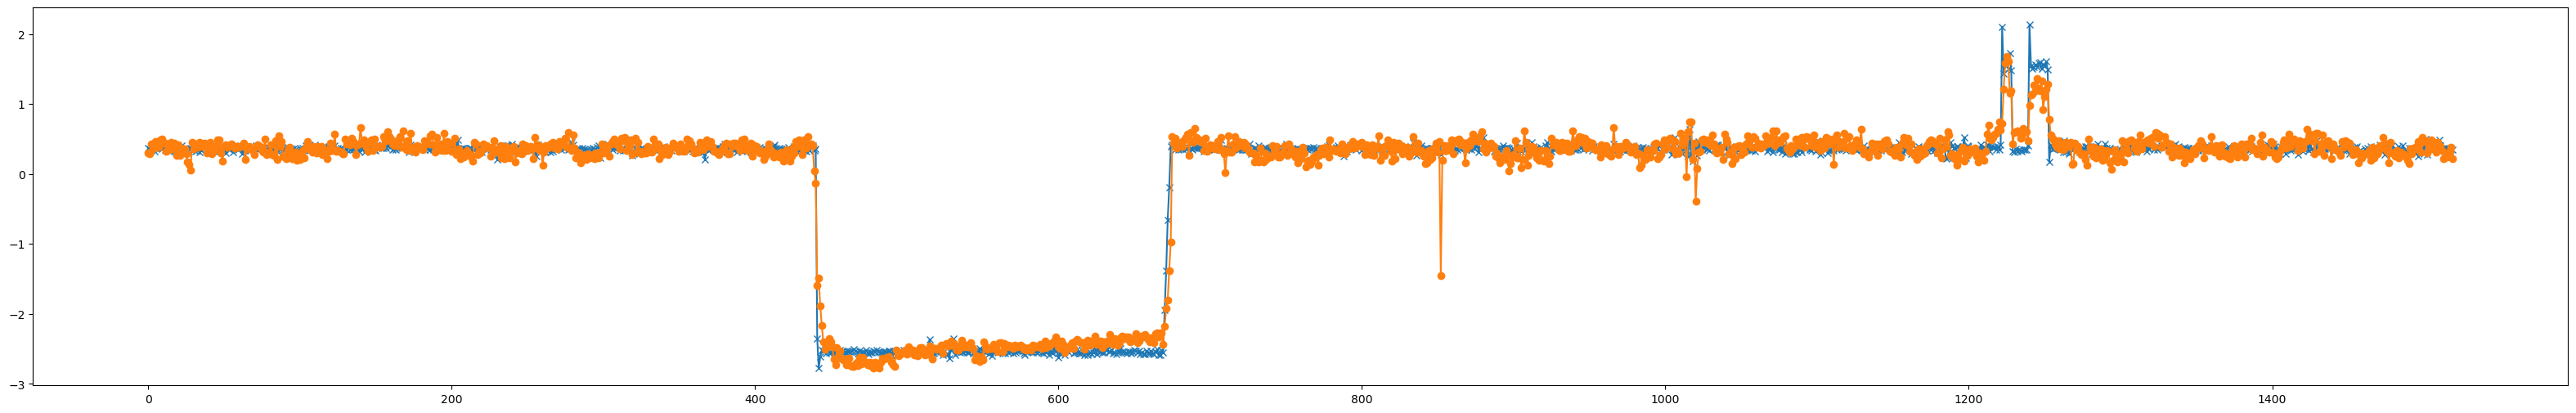

In [63]:
plt.figure(figsize=(40, 6))
plt.plot(y_test_sorted, marker='x')
plt.plot(y_pred, marker='o')
plt.show()